<img src="../_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Introduction to FACET

***

FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.       

***

**Context**

Drilling a water well is dangerous and costly. Costs are driven by the time it takes to finalize a well in order to start pumping water from it. In order to reduce those costs, drillers are usually incentivised to drill at a faster pace. However, drilling faster increases risks of incident which is the reason why the Rate of Penetration (ROP) is a measure constantly monitored.

Utilizing FACET, we will:

1. Apply use machine learning to prevent a water well drilling operation from an incident.
2. Quantify how the ROP impacts the estimated risk.  

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Data and initial feature selection](#Data-and-initial-feature-selection)
3. [Selecting a learner using FACET ranker](#Selecting-a-learner-using-FACET-ranker)
4. [Using the FACET inspector for model inspection](#Using-the-FACET-inspector-for-model-inspection)
5. [FACET univariate simulator: the impact of rate of penetration](#FACET-univariate-simulator:-the-impact-of-rate-of-penetration)
6. [Appendix: generating the dataset](#Appendix:-generating-the-dataset)

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os

    if "cwd" not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")


def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook

    # ignore a useless LGBM warning
    import warnings

    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")


_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings


import matplotlib.pyplot as plt


def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

working dir is 'C:\Projects\facet\facet'
added `C:\Projects\facet\pytools\src` to python paths
added `C:\Projects\facet\facet\src` to python paths
added `C:\Projects\facet\sklearndf\src` to python paths


# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. Other BCG GAMMA packages which simplify pipelining (sklearndf, see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)) and support visualization (pytools, see on [GitHub](https://github.com/BCG-Gamma/pytools)) when using FACET

**Common package imports**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold

**FACET imports**

In [3]:
from facet.data import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateProbabilitySimulator
from facet.simulation.viz import SimulationDrawer
from facet.crossfit import LearnerCrossfit

**sklearndf imports**

Instead of using the "regular" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for `DF` on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [4]:
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.classification.extra import LGBMClassifierDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF

**pytools imports**

pytools (see on [GitHub](https://github.com/BCG-Gamma/pytools)) is an open source library containing general machine learning and visualization utilities, some of which are useful for visualising the advanced model inspection capabilities of FACET.

In [5]:
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer

inheritdoc:no match found for docstring '[see superclass]' in class MatrixMatplotStyle
inheritdoc:no match found for docstring '[see superclass]' in class MatrixReportStyle


# Data and initial feature selection

For the sake of simplicity, we use a simplified artificial dataset, it contains 500 observations, each row representing a drilling operation of the past, the target is the occurrence of drill breakdown (incident). Details and the code used to simulate this dataset can be found in the [Appendix](#Appendix:-generating-the-dataset).

In [6]:
# load the prepared dataframe
df = pd.read_csv(
    "sphinx/source/tutorial/water_drilling_classification_data.csv",
    sep=";",
    encoding="utf-8",
)

# quick look
df.head()

,Weight on bit (kg),Rotation speed (rpm),Depth of operation (m),Mud density (kg/L),Rate of Penetration (ft/h),Temperature (C),Mud Flow in (m3/s),Hole diameter (m),Incident,Inverse Rate of Penetration (h/ft)
0,289.201651,10594.222670,790.947541,2.898840,28.403279,39.539919,50.299606,5.369813,0.0,0.035207
1,341.949835,6962.659505,811.833996,1.677378,27.066685,74.050548,72.140061,5.580490,1.0,0.036946
2,266.831213,11065.697315,619.497649,2.213403,30.556081,45.194728,10.908230,4.374240,0.0,0.032727
3,267.340585,7890.678632,1048.481202,2.683010,23.735377,55.135234,51.029350,6.981177,0.0,0.042131
4,305.977342,12017.344224,613.434303,2.360972,28.502248,60.585239,44.159394,4.217036,1.0,0.035085


In [7]:
# create a FACET sample object
drilling_obs = Sample(observations=df, target_name="Incident")

Next, we perform some initial feature selection using Boruta, a recent approach shown to have quite good performance. The Boruta algorithm seeks to identify and remove features that are no more predictive than random noise. If you are interested further, please see this  [article](https://www.jstatsoft.org/article/view/v036i11).

The `BorutaDF` transformer in our sklearndf package provides easy access to this method. The approach relies on a tree-based learner, usually a random forest. For settings, a `max_depth` of between 3 and 7 is typically recommended, and here we utilise the default setting of 5. However, as this depends on the number of features and the complexity of interactions, one could also explore the sensitivity of feature selection to this parameter. The number of trees is automatically managed by the Boruta feature selector argument `n_estimators="auto"`.

We also use parallelization for the random forest using `n_jobs` to accelerate the Boruta iterations.

In [8]:
df.columns

Index(['Weight on bit (kg)', 'Rotation speed (rpm)', 'Depth of operation (m)',
       'Mud density (kg/L)', 'Rate of Penetration (ft/h)', 'Temperature (C)',
       'Mud Flow in (m3/s)', 'Hole diameter (m)', 'Incident',
       'Inverse Rate of Penetration (h/ft)'],
      dtype='object')

In [9]:
# wrapper class to implement Boruta feature selection
feature_selector = BorutaDF(
    estimator=RandomForestClassifierDF(max_depth=5, random_state=42, n_jobs=-3),
    n_estimators="auto",
    random_state=42,
    verbose=0,
    max_iter=200,
)

# create a pipeline that includes some simple preprocessing (imputation) and Boruta
feature_preprocessing = PipelineDF(
    steps=[("impute", SimpleImputerDF()), ("feature selection", feature_selector)]
)

# run feature selection using Boruta and report those selected
feature_preprocessing.fit(X=drilling_obs.features, y=drilling_obs.target)
print(f"Selected features: {list(feature_preprocessing.feature_names_original_.unique())}")

Selected features: ['Weight on bit (kg)', 'Rotation speed (rpm)', 'Depth of operation (m)', 'Mud density (kg/L)', 'Rate of Penetration (ft/h)', 'Hole diameter (m)', 'Inverse Rate of Penetration (h/ft)']


We can see that the key features that we would expect to impact the safety of the operation are included after the feature selection. A working hypothesis of how each influences the target is: 

- **Weight on bit**: we expect higher weight to increase the likelihood of a failure due to heavier equipment wear

- **Rotation speed**: Too fast rotation speed can lead to overheating and breaking the material, too low rotation renders drilling more difficult and is not economical

- **Depth of operation**: As a simplification we will take for granted that the deeper we dig, the denser the soil will be, increasing the likelihood of either a collapse or breaking equipment wear

- **Mud density**: Mud density needs to match soil density to avoid well collapse (formation falling in well and blocking pipe) or mud loss (mud flowing in the formation)

- **Rate of Penetration**: A higher ROP leads to more wear & tear of the equipment and thus we expect a positive effect

- **Hole diameter**: Thinner wholes are used in deeper sections of the well hence usually relate to more dangerous zones

- **Inverse Rate of Penetration**: As described by its name, this feature is the inverse of the ROP

In [10]:
# get original feature names
feature_preprocessing.feature_names_original_.unique()

array(['Weight on bit (kg)', 'Rotation speed (rpm)',
       'Depth of operation (m)', 'Mud density (kg/L)',
       'Rate of Penetration (ft/h)', 'Hole diameter (m)',
       'Inverse Rate of Penetration (h/ft)'], dtype=object)

In [11]:
# create a FACET sample object with features selected by Boruta
drilling_obs_reduced_featset = drilling_obs.keep(feature_names=
    feature_preprocessing.feature_names_original_.unique()
)

# Selecting a learner using FACET ranker

FACET implements several additional useful wrappers which further simplify comparing and tuning a larger number of models and configurations: 

- `LearnerGrid`: allows you to pass a learner pipeline (i.e., classifier + any preprocessing) and a set of hyperparameters
- `LearnerRanker`: multiple LearnerGrids can be passed into this class as a list - this allows tuning hyperparameters both across different types of learners in a single step and ranks the resulting models accordingly

The following learners and hyperparameter ranges will be assessed using 5 repeated 5-fold cross-validation:


1. **Random forest**: with hyperparameters
    - min_samples_leaf: [8, 11, 15]

  
2. **Light gradient boosting**: with hyperparameters
    - min_samples_leaf: [8, 11, 15]

Note if you want to see a list of hyperparameters you can use `classifier_name().get_params().keys()` where `classifier_name` could be for example `RandomForestClassifierDF` and if you want to see the default values, just use `classifier_name().get_params()`.

Note that ranking uses the average performance minus two times the standard deviation, so that we consider both the average performance and variability when selecting a classifier. The default scoring metric for classification is accuracy.

First, we specify the classifiers we want to train using `ClassifierPipelineDF` from sklearndf. Note here we also include feature preprocessing steps.

In [12]:
# random forest learner
rforest_clf = ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(n_estimators=500, random_state=42),
)

# light gradient boosting learner
lgbm_clf = ClassifierPipelineDF(
    classifier=LGBMClassifierDF(random_state=42),
)

Then we create a list of learner grids where each learner grid is created using `LearnerGrid` and allows us to associate a `ClassifierPipelineDF` with a specified set of hyperparameter via the `learner_parameters` argument. Note this structure allows us to easily include additional classifiers and hyperparameters.

In [13]:
# define learner grid
clf_grid = [
    LearnerGrid(
        pipeline=rforest_clf, learner_parameters={"min_samples_leaf": [8, 11, 15]}
    ),
    LearnerGrid(
        pipeline=lgbm_clf, learner_parameters={"min_data_in_leaf": [8, 11, 15]}
    ),
]

We now fit the grid defined above using the `LeanerRanker`, which will run a gridsearch (or random search if defined) using 5 repeated 5-fold cross-validation.

In [14]:
# create cv iterator 5 repeated 5-fold
cv_approach = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# fit ranker
model_ranker = LearnerRanker(grids=clf_grid, cv=cv_approach, n_jobs=-3).fit(
    sample=drilling_obs_reduced_featset
)

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


To see the configuration of the best selected model, we can access the `best_model_` property of the fitted `LearnerRanker` object.

In [15]:
model_ranker.best_model_

ClassifierPipelineDF(classifier=LGBMClassifierDF(min_data_in_leaf=15,
                                                 random_state=42))

We can see how each model scored using the `summary_report()` method of the `LearnerRanker`.

In [16]:
# let's look at performance for the top ranked classifiers
model_ranker.summary_report()

ranking_score accuracy_score                          classifier  \
                             mean       std                      type   
rank                                                                    
0         0.766365         0.8520  0.042817          LGBMClassifierDF   
1         0.753891         0.8452  0.045654          LGBMClassifierDF   
2         0.739825         0.8316  0.045888          LGBMClassifierDF   
3         0.703298         0.7712  0.033951  RandomForestClassifierDF   
4         0.685410         0.7552  0.034895  RandomForestClassifierDF   
5         0.677873         0.7464  0.034264  RandomForestClassifierDF   

                                        
     min_samples_leaf min_data_in_leaf  
rank                                    
0                 NaN             15.0  
1                 NaN             11.0  
2                 NaN              8.0  
3                 8.0              NaN  
4                11.0              NaN  
5                15.0              NaN

# Using the FACET inspector for model inspection

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for a given observation. SHAP values are computed for every feature and observation.

The FACET `LearnerInspector` computes SHAP values for each crossfit (i.e., a CV fold or bootstrap resample) using the best model identified by the `LearnerRanker`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding feature redundancy and synergy. Redundancy and synergy are calculated using the new algorithm FACET implements for using SHAP values to understand model predictions.

The definitions are as follows:

- **Redundancy** represents how much information is shared between two features contributions to the model predictions. For example, temperature and pressure in a pressure cooker are redundant features for predicting cooking time since pressure will rise relative to the temperature, and vice versa. Therefore, knowing just one of either temperature or pressure will likely enable the same predictive accuracy. Redundancy is expressed as a percentage ranging from 0% (full uniqueness) to 100% (full redundancy).


- **Synergy** represents how much the combined information of two features contributes to the model predictions. For example, given features X and Y as coordinates on a chess board, the colour of a square can only be predicted when considering X and Y in combination. Synergy is expressed as a percentage ranging from 0% (full autonomy) to 100% (full synergy).

Both cases can apply at the same time, i.e. a pair of features can use some information synergistically while using other information redundantly.

To analyse redundancy for all possible feature pairings, the approach is:

1.	Calculate the feature redundancy matrix using SHAP value decomposition - this gives us pairwise redundancy between features, in the range of 0.0 (fully unique contributions) and 1.0 (fully redundant contributions)
2.	Transform the feature redundancy matrix into a feature distance matrix, where distance is expressed as (1.0 - redundancy)
3.	Perform hierarchical, single-linkage clustering on the distance matrix, thus identifying groups of low-distance, redundant features which activate “in tandem” to predict the outcome

The same approach can be used to analyse synergy.

The inspector can calculate all of this with a single method call, but also offers methods to access the intermediate results of each step. A lightweight visualization framework is available to render the results in different styles.

SHAP values from the `LearnerInspector` can also be used with the SHAP package plotting functions for sample and observation level SHAP visualizations, such as SHAP distribution plots, dependency plots, force plots and waterfall plots.

In [18]:
model_inspector = LearnerInspector(n_jobs=-3)
model_inspector.fit(crossfit=model_ranker.best_model_crossfit_)

redundancy_matrix = model_inspector.feature_redundancy_matrix(symmetrical=True, clustered=False)
synergy_matrix = model_inspector.feature_synergy_matrix(symmetrical=True, clustered=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


**Feature redundancy**

When plotting out the feature redundancy, we can see that there are some feature pairs which share similar information towards our model predictions. In this case, these feature pairs are **(depth of the operation, hole diameter)** and **(ROP, Inverse ROP)**. 
Intuitively, we can see why **(depth of the operation, hole diameter)** have redundancy, as the depth of operation and the hole diameter are highly connected as drillers use thinner drilling bits as they drill deeper into the earth.
We also observe an expected redundancy for **(ROP, Inverse ROP)**, as the Inverse ROP is just the inverse transformation of ROP.

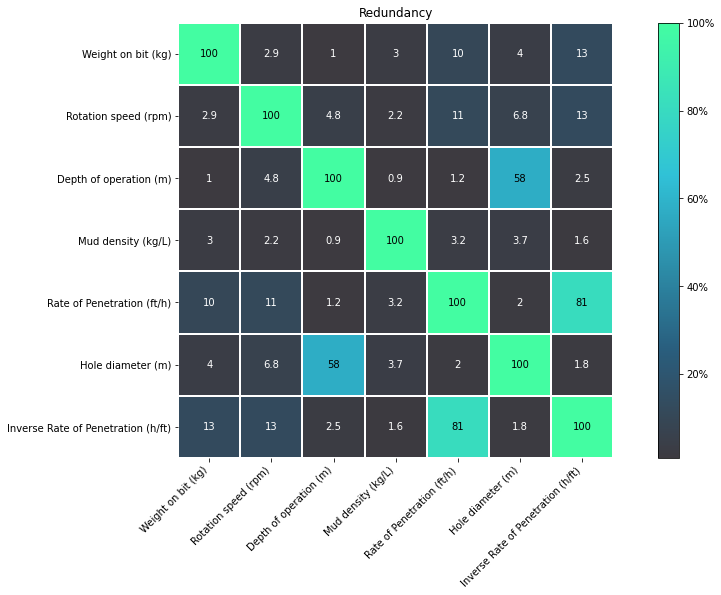

In [19]:
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy")

**Feature synergy**

When looking at the synergy matrix, we can easily figure out which of the features have an interaction effect on the target. We see that the **weight on the bit and the rotation speed in combination appear to have a high synergy.** This seems sensible in context, as drilling with both a high bit weight and a high pace can have a disproportionately large impact on the wear of the equipment, and so drastically increase the likelihood of failure.

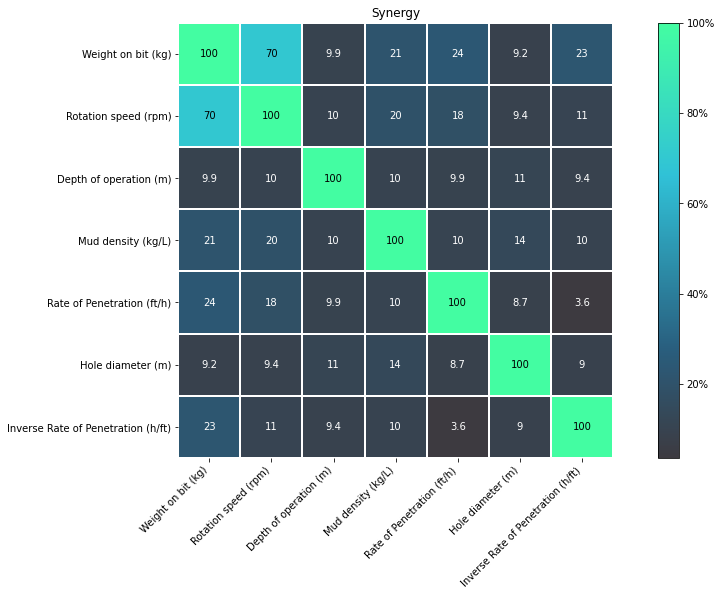

In [20]:
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

**Removing redundant features**

As the picture above shows a high redundancy level between the ROP and the Inverse ROP, both features compete in terms of feature importance. The dendrogram below shows that we should remove one to help orthogonalise the feature set before simulation. We could also consider removing one of Hole diameter and Depth of Operation however, for the purpose of this tutorial, we will remove Inverse ROP and retain ROP, which is more interpretable.

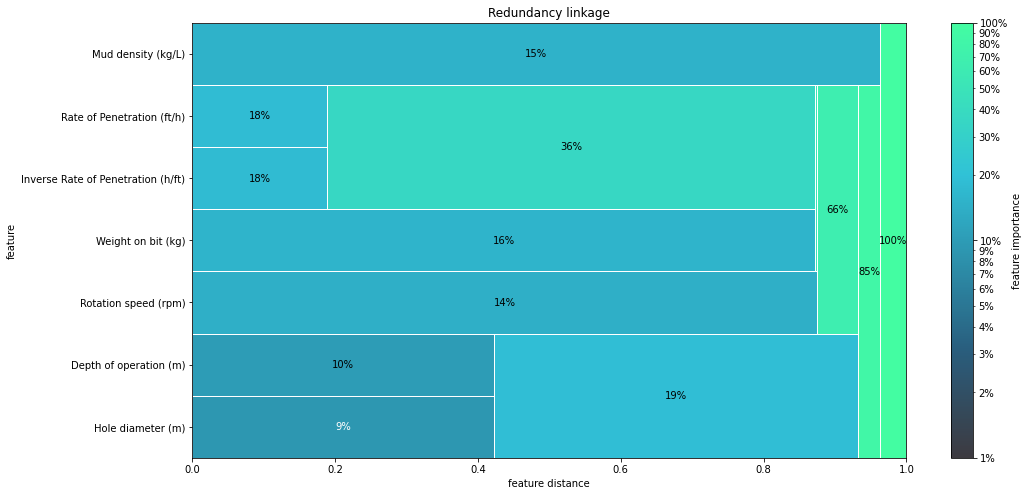

In [21]:
redundancy = model_inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

The reason we want to engineer an orthogonal set of features is so we can use the univariate simulator. An orthogonal feature set of is needed so that the artificially created samples stay plausible. Indeed, not removing the Inverse ROP feature from the set would lead to unrealistic artificial observations while using the univariate simulator.

In [22]:
# remove redundant feature Inverse ROP
redundant_features = ["Inverse Rate of Penetration (h/ft)"]
drilling_obs_not_redundant = drilling_obs_reduced_featset.drop(feature_names=redundant_features)

model_ranker = LearnerRanker(grids=clf_grid, cv=cv_approach, n_jobs=-3).fit(
    sample=drilling_obs_not_redundant
)

model_inspector = LearnerInspector(n_jobs=-3)
model_inspector.fit(crossfit=model_ranker.best_model_crossfit_)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


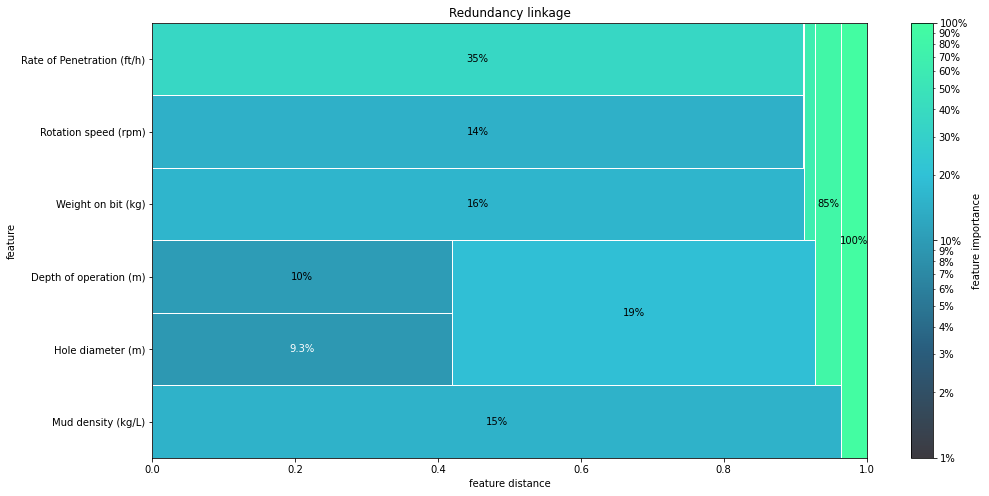

In [23]:
redundancy = model_inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

Now that our feature set is looking more linearly independent, we can start making simulations to gain knowledge into how ROP will impact failure likelihood.

Note that removing the Inverse ROP has given more feature importance to the ROP, which is now the most important feature.

# FACET univariate simulator: the impact of rate of penetration

The ROP is a parameter very much monitored while drilling a well as it is a tradeoff between safety and economy, it is safer to drill at a low pace but much costlier as it takes more time. It has also the highest feature importance in our model (see dendrogram above). Let's use a simulation to get a sense of how the failure likelihood behaves if we simulate changes in the ROP applied.

As the basis for the simulation, we divide the feature into relevant partitions: 

- We use FACET's `ContinuousRangePartitioner` to split the range of observed values of ROP into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best `LearnerCrossfit` acquired from the ranker, the simulator now re-predicts all targets using the models trained for all folds and determines the average predicted probability of the target variable resulting from this.
- The FACET `SimulationDrawer` allows us to visualise the result; both in a matplotlib and a plain-text style


Finally, because FACET can use bootstrap cross validation, we can create a crossfit from our previous `LearnerRanker` best model to perform the simulation so we can quantify the uncertainty by using bootstrap confidence intervals.

In [24]:
# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=model_ranker.best_model_,
    cv=BootstrapCV(n_splits=1000, random_state=42),
    n_jobs=-3,
    verbose=0,
).fit(sample=drilling_obs_not_redundant)

# set-up and run a simulation
SIM_FEATURE = "Rate of Penetration (ft/h)"
rop_bins = ContinuousRangePartitioner()
rop_simulator = UnivariateProbabilitySimulator(crossfit=boot_crossfit, n_jobs=-3)
rop_simulation = rop_simulator.simulate_feature(feature_name=SIM_FEATURE, partitioner=rop_bins)

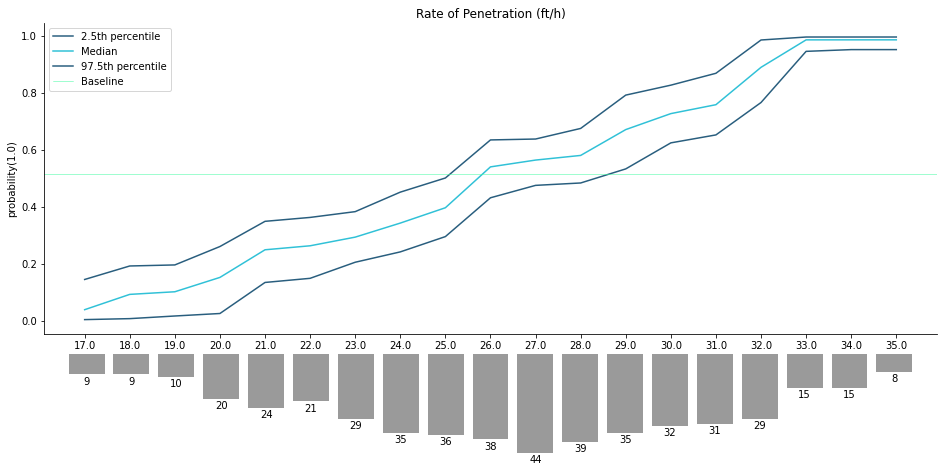

In [25]:
SimulationDrawer().draw(data=rop_simulation, title=SIM_FEATURE)

The simulation can be used to obtain insight on failure likelihood changes depending on the ROP applied. As an example, the simulation suggests that operating with an ROP above 30ft/h can lead to an incident likelihood above 70%.

# Appendix: generating the dataset

For the sake of simplicity, we use a simplified artificial dataset, it contains 500 observations, each row representing a drilling operation of the past, the target is the occurrence of drill breakdown (incident).

```python
# additional imports
from scipy.linalg import toeplitz
from sklearn.preprocessing import MinMaxScaler
from typing import Union
```

```python
def drilling_data_sim():
    
    # set sample size
    n=500

    # set seed
    np.random.seed(seed=4763546)

    # add 6 uncorrelated N(0,1) features, U(-1,1) for non-linear feature and a single surrogate linear feature
    col_names = ['TwoFactor1', 'TwoFactor2', 'Linear1', 'Linear2', 'Linear3', 'Noise1']
    tmp_data = pd.DataFrame(np.random.normal(size=(n, 6)), columns=col_names)
    tmp_data['Nonlinear1'] = pd.Series(np.random.uniform(low=-1.0, high=1.0, size=n))
    tmp_data['Linear1_prime'] = tmp_data['Linear1'] + np.random.normal(0, 0.05, size=n)

    # generate linear predictor
    lp = 8 * tmp_data.TwoFactor1 * tmp_data.TwoFactor2 \
         + tmp_data.Nonlinear1 ** 3 + 2 * np.exp(-6 * (tmp_data.Nonlinear1 - 0.3) ** 2) + \
         2.5 * tmp_data.Linear1 + -1.75 * tmp_data.Linear2 + 4.0 * tmp_data.Linear3

    # convert to probability
    prob = 1 / (1 + np.exp(-lp))

    # generate target
    tmp_data['target'] = np.where(prob <= np.random.uniform(size=n), 0, 1)

    return tmp_data
```

```python
def scale_var(df: pd.DataFrame, 
              feature_name: str, 
              min_: Union[int, float]=0, 
              max_: Union[int, float]=1) -> np.array: 
    """
    Takes in a data frame and applies a min-max scaler to given bounds for a single column
    """
    
    scaler = MinMaxScaler(feature_range=(min_, max_))
    scaled_arr = scaler.fit_transform(df[[feature_name]]).reshape(1, -1)[0]
    
    return scaled_arr
```

```python
def refactor_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df.rename({ 
        "TwoFactor1": "Weight on bit (kg)", # higher weight --> higher weight will increase risks of danger 
        "TwoFactor2": "Rotation speed (rpm)", # Rotation speed of the drilling bit (too fast rotation can lead to overheating, too low rotation renders drilling mnore difficult)         
        "Linear1": "Depth of operation (m)", # lower point of the well
        "Linear1_prime": "Hole diameter (m)", # Diameter of the hole (diameter diminishes as depth increases)
        "Nonlinear1": "Mud Flow in (m3/s)", # Speed of mud circulation
        "Linear2": "Mud density (kg/L)", # need to have equal mud and soil density to avoid well collapse (formation falling in well and blocking pipe) or mud loss (mud flowing in the formation)
        "Linear3": "Rate of Penetration (ft/h)", # higher RoP will provide less time for drilling engineers to observe real time data and adjust drilling parameter set up -> leading to a higher risk of incident (but more economic to drill faster)
        "Noise1": "Temperature (C)", # Temperature at the drilling bit 
        "target": "Incident"
    }, axis=1, inplace=True)
    
    scaling_dict = { 
        'Weight on bit (kg)': [100, 500], 
        'Rotation speed (rpm)': [900, 15000],
        'Rate of Penetration (ft/h)': [10, 40],
        'Mud density (kg/L)': [0.5, 4],
        'Hole diameter (m)': [0.5, 10], 
        'Temperature (C)': [0, 100], 
        'Depth of operation (m)': [0, 1500], 
        'Mud Flow in (m3/s)': [0, 100],
        'Incident': [0, 1]
    }

    for k,v in scaling_dict.items(): 
        df.loc[:, k] = scale_var(df, k, v[0], v[1])
        
    df["Inverse Rate of Penetration (h/ft)"] = 1/df["Rate of Penetration (ft/h)"]
        
    return df
```

```python
# generate and save the data for the example
df = drilling_data_sim()
df = refactor_dataset(df)
df.to_csv("sphinx/source/tutorial/water_drilling_classification_data.csv", sep=";", encoding="utf-8", index=False)
```